## Abnormality Detection in bone X-Rays with CNN
**CNN Conv-Pool-Conv-Pool Architecture**

* Katerina Kazantza (p3351801)

In [48]:
import numpy as np
import pandas as pd
from PIL import Image
import PIL
import pydot
from tensorflow.keras import layers
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from numpy import asarray

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,auc
from tensorflow.keras.regularizers import l2


### Load Data

In [3]:
dataset_root = Path('data/MURA-v1.1')

In [4]:
list(dataset_root.iterdir())

[WindowsPath('data/MURA-v1.1/train'),
 WindowsPath('data/MURA-v1.1/train_image_paths.csv'),
 WindowsPath('data/MURA-v1.1/train_labeled_studies.csv'),
 WindowsPath('data/MURA-v1.1/valid'),
 WindowsPath('data/MURA-v1.1/valid_image_paths.csv'),
 WindowsPath('data/MURA-v1.1/valid_labeled_studies.csv')]

In [5]:
train_imgpaths_df = pd.read_csv(dataset_root/'train_image_paths.csv', header=None, names=['filename'])
train_imgpaths_df['class'] = (train_imgpaths_df.filename
               .str.extract('study.*_(positive|negative)'))
train_imgpaths_df.head()

,filename,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive


In [6]:
valid_imgpaths_df = pd.read_csv(dataset_root/'valid_image_paths.csv', header=None, names=['filename'])
valid_imgpaths_df['class'] = (valid_imgpaths_df.filename
               .str.extract('study.*_(positive|negative)'))
valid_imgpaths_df.head()

,filename,class
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive


### Data Augmentation
We use Keras’s ImageDataGenerator to perform image augmentation and scale the size of images as 224×224. Then we generate the train and validation dataframes in order to feed the flow_from_dataframe method which have the mapping between filenames of the images and their labels.

In [7]:
def generate_df(dataset_root, csv_name):
    df = pd.read_csv(dataset_root/csv_name, header=None, names=['filename'])
    df['class'] = (df.filename
               .str.extract('study.*_(positive|negative)'))
    return df

We use validation_split to split the dataset. We have to specify which set is to be used for which flow_from_dataframe function. We set __*subset*__ argument as __*'training' or 'validataion'.*__

In [36]:
# datagenerator = ImageDataGenerator(rescale = 1. / 255, validation_split=0.25)
datagenerator = ImageDataGenerator(rescale = 1. / 255, validation_split=0.15,
                                   brightness_range=[0.2,1.0],zoom_range=[0.5,1.0])


train_generator = datagenerator.flow_from_dataframe(generate_df(dataset_root, 'train_image_paths.csv'),
                                        directory=dataset_root.parent,
                                        subset="training",
                                        batch_size=32,
                                        seed=42,
                                        shuffle=True,
                                        target_size=(224, 224),
                                        class_mode='binary')



valid_generator = datagenerator.flow_from_dataframe(generate_df(dataset_root, 'train_image_paths.csv'),
                                        directory=dataset_root.parent,
                                        subset="validation",
                                        batch_size=32,
                                        seed=42,
                                        shuffle=True,
                                        target_size=(224, 224),
                                        class_mode='binary')



test_datagenerator = ImageDataGenerator(rescale = 1. / 255)
test_generator = test_datagenerator.flow_from_dataframe(generate_df(dataset_root, 'valid_image_paths.csv'),
                                        directory=dataset_root.parent,
                                        batch_size=32,
                                        shuffle=False,
                                        target_size=(224, 224),
                                        class_mode='binary')

Found 31287 validated image filenames belonging to 2 classes.
Found 5521 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


In [37]:
tf.test.is_gpu_available()

True

### Build Model CNN Conv-Pool-Conv-Pool

#### Create Model

In [49]:
def create_model(
        classes,
        filter_size,
        input_shape,
        optimizer,
        epochs=20,
        conv_layers=2,
        conv_activation='relu',
        conv_dropout=False,
        output_activation='sigmoid',
        verbose=0):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=8*(2**i),
            kernel_size=(3,3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            kernel_regularizer=l2(0.01), 
            bias_regularizer=l2(0.01),
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=0.3,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Define the output layer.
    output = Dense(
        units=classes,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [50]:
# Using Adam
optimizer = Adam()
epochs = 50
classes=1
input_shape=(224, 224, 3)
filter_size = {0:3, 1:3, 2:5, 3:5, 4:7, 5:7, 6:9, 7:11}

conv_model_adam = create_model(
    classes=classes,
    input_shape=input_shape,
    optimizer=optimizer,
    epochs=epochs,
    conv_activation='relu',
    conv_dropout=True,
    conv_layers=5,
    output_activation='sigmoid',
    filter_size=filter_size
)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 224, 224, 8)       224       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 112, 112, 8)       0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 112, 112, 8)       0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
MaxPool2D-2 (MaxPooling2D)   (None, 56, 56, 16)        0         
_________________________________________________________________
Dropout-2 (Dropout)          (None, 56, 56, 16)        0   

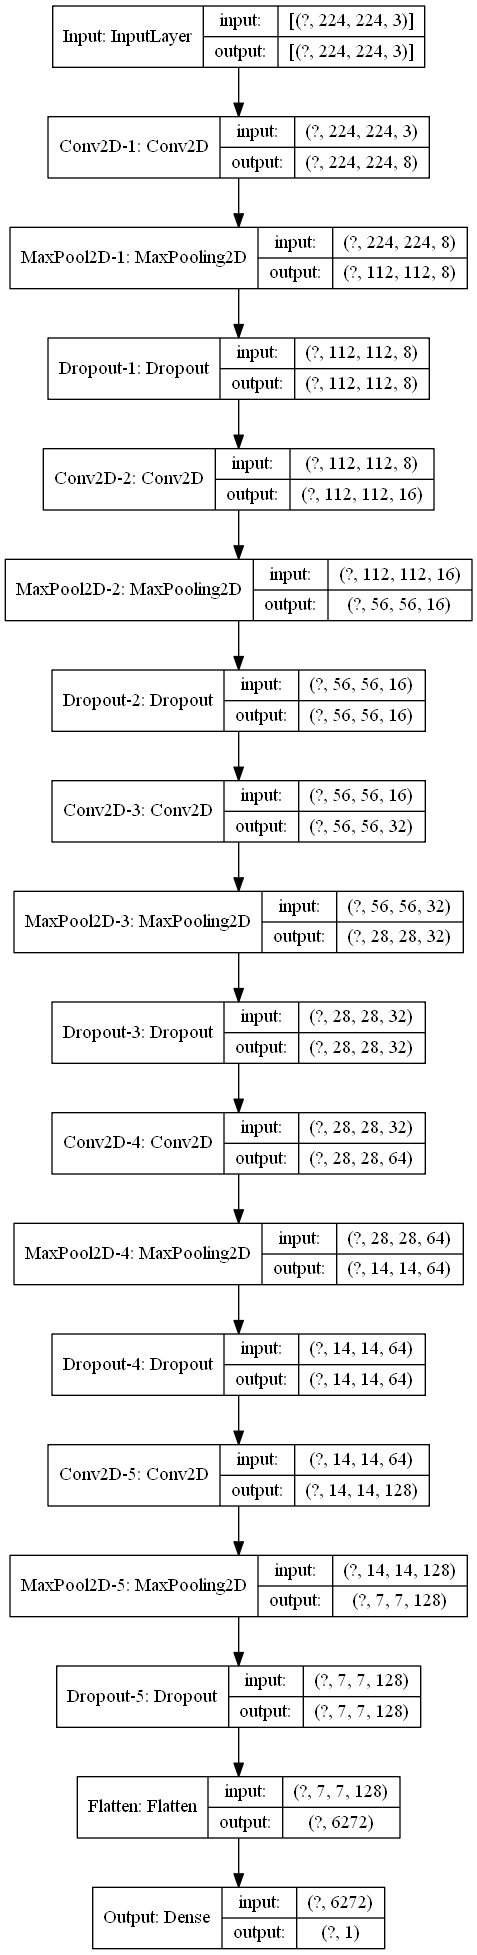

In [51]:
plot_model(conv_model_adam, to_file='model_architectures/cnn_architecture.png', show_shapes=True, show_layer_names=True)

#### Use Callbacks <br>
* Usage of **ModelCheckpoint** callback to save weights when the model performace is improved based on validation loss metric
* Usage of **EarlyStopping.** Stop training when the monitored metric (validation loss) has stopped improving. 
* Usage of **ReduceLROnPlateau** to reduce learning rate by 0.1 if the learning rate stops increasing.

In [52]:
# checkpoint
filepath="model_checkpoints/cnn.weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, min_lr=0.0001)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


callbacks_list = [checkpoint, early_stopping, reduce_lr]

#### Train Model

Data augmentation is performed when fitting the model if the first argument provided is a Python generator object.  
By fitting the model using **ImageDataGenerator**, at every new epoch new random image transformations will be applied and in this way we train with a little different set of images each time. This is important to avoid overfitting.

In [53]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

with tf.device('/device:GPU:0'):
    history = conv_model_adam.fit(
            train_generator,
            steps_per_epoch=STEP_SIZE_TRAIN,
            validation_data=valid_generator,
            validation_steps=STEP_SIZE_VALID,
            epochs=epochs,
            callbacks=callbacks_list,
        )
print('Finished training.')
print('------------------')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 977 steps, validate for 172 steps
Epoch 1/50
976/977 [============================>.] - ETA: 0s - loss: 0.7352 - accuracy: 0.6578
Epoch 00001: val_loss improved from inf to 1.03085, saving model to model_checkpoints/cnn.weights.best.hdf5
977/977 [==============================] - 546s 559ms/step - loss: 0.7352 - accuracy: 0.6576 - val_loss: 1.0308 - val_accuracy: 0.2449
Epoch 2/50
976/977 [============================>.] - ETA: 0s - loss: 0.6436 - accuracy: 0.6579
Epoch 00002: val_loss improved from 1.03085 to 0.87691, saving model to model_checkpoints/cnn.weights.best.hdf5
977/977 [==============================] - 540s 553ms/step - loss: 0.6436 - accuracy: 0.6579 - val_loss: 0.8769 - val_accuracy: 0.2449
Epoch 3/50
976/977 [============================>.] - ETA: 0s - loss: 0.6436 - accuracy: 0.6578
Epoch 00003: val_loss did not improve from 0.87691

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974

#### Evaluate on test dataset

In [54]:
cnn_eval_model = conv_model_adam.evaluate(test_generator, steps=STEP_SIZE_TEST)

  ...
    to  
  ['...']
99/99 [==============================] - 12s 119ms/step - loss: 0.7231 - accuracy: 0.5170


In [60]:
def plot_history(hs, epochs, metric):
    print()
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()


Train Loss     : 0.64280
Validation Loss: 0.90550
Test Loss      : 0.72308
---
Train Accuracy     : 0.65775
Validation Accuracy: 0.24491
Test Accuracy      : 0.51705



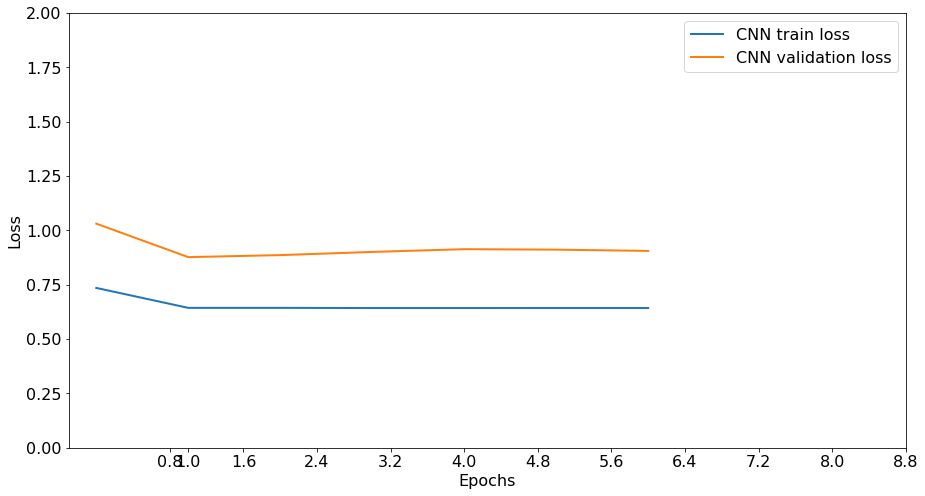

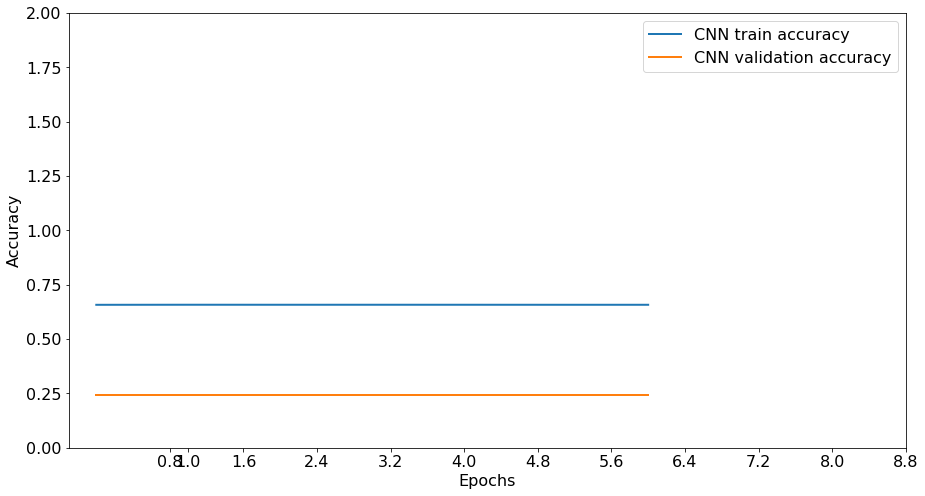

In [61]:
print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(cnn_eval_model[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(cnn_eval_model[1]))


# Plot train and validation error per epoch.
plot_history(hs={'CNN': history}, epochs=8, metric='loss')
plot_history(hs={'CNN': history}, epochs=8, metric='accuracy')

#### Predict Output

In [62]:
def extract_patient(string):
    patient = string.split('/')[3]+"/"+string.split('/')[4]
    return patient

def class_binarizer(string):
    if string=="positive":
        return 1
    return 0

def probability_binarizer(prob):
    if prob>=0.5:
        return 1
    return 0

def compareActualVsPred(x):
    if x['predClass']==x['actualClass']:
        return 1
    return 0

def create_test_df_for_predict(valid_imgpaths_df):
    valid_imgpaths_df['patient_study'] = valid_imgpaths_df['filename'].apply(extract_patient)
    valid_imgpaths_df['actualClass'] = valid_imgpaths_df['class'].apply(class_binarizer)
    valid_imgpaths_df['predClass'] = valid_imgpaths_df['predictedProb'].apply(probability_binarizer)
    valid_imgpaths_df['predVsActual']= valid_imgpaths_df.apply(compareActualVsPred, axis=1)
    return valid_imgpaths_df

In [63]:
test_generator.reset()
cnn_predictionsdf = pd.DataFrame(conv_model_adam.predict(test_generator),columns=["predictedProb"])

In [64]:
cnn_test_df = valid_imgpaths_df
cnn_test_df = pd.concat([cnn_test_df, cnn_predictionsdf], axis=1)
cnn_test_df = create_test_df_for_predict(cnn_test_df)
cnn_test_df

,filename,class,predictedProb,patient_study,actualClass,predClass,predVsActual
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,0.362329,patient11185/study1_positive,1,0,0
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,0.362329,patient11185/study1_positive,1,0,0
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,0.362329,patient11185/study1_positive,1,0,0
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,0.362329,patient11185/study1_positive,1,0,0
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,0.362329,patient11186/study1_positive,1,0,0
...,...,...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,negative,0.362329,patient11967/study1_negative,0,0,1
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,negative,0.362329,patient11967/study1_negative,0,0,1
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,negative,0.362329,patient11738/study1_negative,0,0,1
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,negative,0.362329,patient11738/study1_negative,0,0,1


#### Averaging our prediction for each study

In [65]:
cnn_test_avg= cnn_test_df.groupby(['patient_study','actualClass']).agg(
    suma=('predVsActual', 'sum'), counta=('actualClass', 'count'),)
cnn_test_avg = cnn_test_avg.reset_index()
cnn_test_avg['percentage'] = cnn_test_avg['suma'] / cnn_test_avg['counta']

In [66]:
def majorityBinarizer(x):
    if(x['percentage']>=0.5):
        return x['actualClass']
    else:
        if x['actualClass']==1:
            return 0
    return 1
cnn_test_avg['majorityClass'] = cnn_test_avg.apply(majorityBinarizer, axis=1)

In [67]:
print('Classification Report')
print(classification_report(cnn_test_avg['actualClass'], cnn_test_avg['majorityClass'], target_names=["Negative","Positive"]))

Classification Report
              precision    recall  f1-score   support

    Negative       0.53      1.00      0.70       539
    Positive       0.00      0.00      0.00       469

    accuracy                           0.53      1008
   macro avg       0.27      0.50      0.35      1008
weighted avg       0.29      0.53      0.37      1008



c:\users\kate\pycharmprojects\deeplearning_xrays\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Roc & AUC

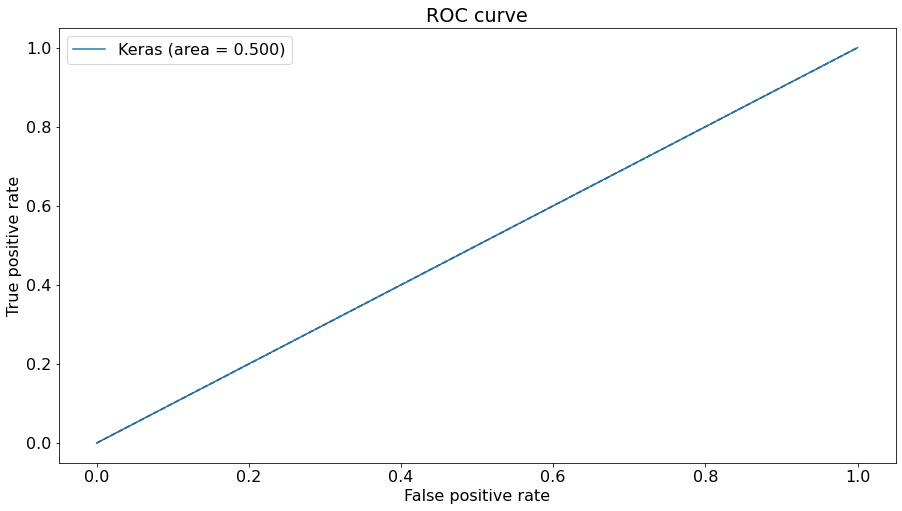

In [68]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(cnn_test_avg['actualClass'], cnn_test_avg['majorityClass'])
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()